In [1]:
from __future__ import print_function
import os, sys
sys.path.insert(0, os.environ['PROJECT_PATH'])

In [2]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

sns.set()
%matplotlib inline

In [3]:
path_to_locs = os.path.join(os.environ['DATA_PATH'], 'interim', 'sample_meetup_locations.csv')
sample_loc_df = pd.read_csv(path_to_locs, encoding='latin1')

In [4]:
path_to_sample_events = os.path.join(os.environ['DATA_PATH'], 'raw', 'topics', 'sample_events.csv')

In [5]:
sample_events_df = pd.read_csv(path_to_sample_events, encoding='latin1')

In [6]:
print(sample_events_df.shape, sample_loc_df.shape)

(119, 6) (65, 8)


In [7]:
extra_columns = [ 'City', 'Country', 'ZipCode', 'State', 'Latitude', 'Longitude' ]
master_df = pd.merge(sample_events_df, sample_loc_df, left_on=['latitude', 'longitude'], 
                     right_on=['Latitude', 'Longitude'], how='inner').drop(extra_columns, axis=1)
# print(sample_events_df.shape, master_df.shape)
master_df.head()

,id,time,group.category.id,yes_rsvp_count,latitude,longitude,MSA_NAME,MSA_CODE
0,245649377,1517707800000,23,8,39.96,-105.49,"Boulder, CO Metro Area",14500.0
1,245764757,1513641600000,23,28,40.05,-105.21,"Boulder, CO Metro Area",14500.0
2,xdfgqnywqbxb,1513643400000,15,10,40.05,-105.21,"Boulder, CO Metro Area",14500.0
3,245577545,1513648800000,28,4,40.05,-105.21,"Boulder, CO Metro Area",14500.0
4,245675561,1513733400000,23,28,40.05,-105.21,"Boulder, CO Metro Area",14500.0


## Exploring the time events took place

In [8]:
master_df['formatted_time'] = pd.to_datetime(master_df['time'], unit='ms')
master_df.head()

,id,time,group.category.id,yes_rsvp_count,latitude,longitude,MSA_NAME,MSA_CODE,formatted_time
0,245649377,1517707800000,23,8,39.96,-105.49,"Boulder, CO Metro Area",14500.0,2018-02-04 01:30:00
1,245764757,1513641600000,23,28,40.05,-105.21,"Boulder, CO Metro Area",14500.0,2017-12-19 00:00:00
2,xdfgqnywqbxb,1513643400000,15,10,40.05,-105.21,"Boulder, CO Metro Area",14500.0,2017-12-19 00:30:00
3,245577545,1513648800000,28,4,40.05,-105.21,"Boulder, CO Metro Area",14500.0,2017-12-19 02:00:00
4,245675561,1513733400000,23,28,40.05,-105.21,"Boulder, CO Metro Area",14500.0,2017-12-20 01:30:00


In [9]:
from datetime import datetime
from datetime import timedelta

curr_date = datetime.now().date()

start_of_curr_month = curr_date.replace(day=1)
three_months_from_now = start_of_curr_month + timedelta(days=3*32)
three_months_from_now = three_months_from_now.replace(day=curr_date.day)

# restricting to events taking place three months from now
master_df = master_df[ master_df['formatted_time'] <= three_months_from_now]

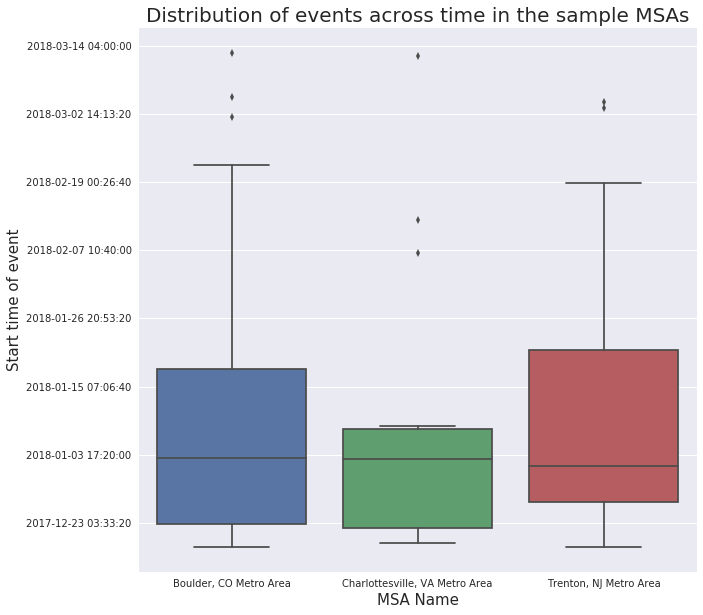

In [10]:
plt.subplots(figsize=(10, 10))
ax = sns.boxplot(x='MSA_NAME', y='time', data=master_df)

yticks = ax.get_yticks()
ax.set_yticklabels([pd.to_datetime(tm, unit='ms') for tm in yticks])
ax.axes.set_title("Distribution of events across time in the sample MSAs",fontsize=20)
ax.set_xlabel("MSA Name",fontsize=15)
ax.set_ylabel("Start time of event",fontsize=15)

print()

## Exploring the number of events across the sample MSAs 

In [11]:
master_df.groupby([ 'MSA_CODE', 'MSA_NAME' ]).count()

,,id,time,group.category.id,yes_rsvp_count,latitude,longitude,formatted_time
MSA_CODE,MSA_NAME,,,,,,,
14500.0,"Boulder, CO Metro Area",52,52,52,52,52,52,52
16820.0,"Charlottesville, VA Metro Area",15,15,15,15,15,15,15
45940.0,"Trenton, NJ Metro Area",38,38,38,38,38,38,38


## Exploring the popularity of events in each category across the sample MSAs 

### By raw event count 

In [12]:
import requests

url_template = "https://api.meetup.com/2/categories?&sign=true&photo-host=public&page=40&key={api_key}"

res = requests.get(url_template.format(api_key=os.environ['API_KEY']))

payload = res.json()

category_ids = { item['id']: item['name'] for item in payload['results'] }

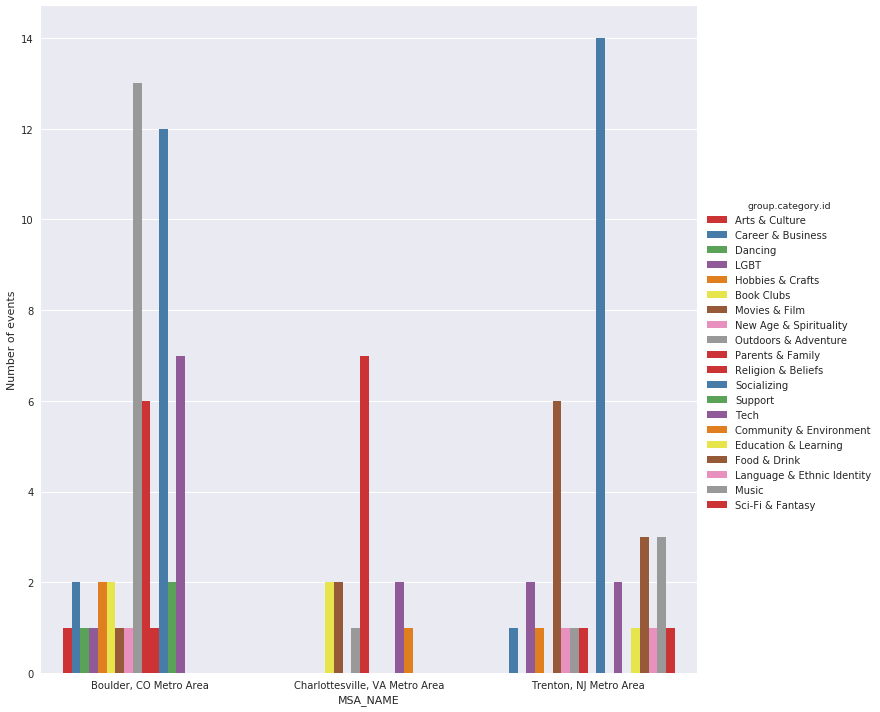

In [14]:
events_count = master_df.groupby(['MSA_CODE', 'MSA_NAME', 'group.category.id']).count().reset_index()

events_count['group.category.id'] = events_count['group.category.id'].apply(lambda x: category_ids[x])

g = sns.factorplot(x='MSA_NAME', y='id', hue='group.category.id', palette=sns.color_palette('Set1', 10), 
                   size=10, kind='bar', data=events_count)
g.set_ylabels('Number of events')
print()

### Top 5 Categories

In [15]:
trenton_top5 = events_count[ events_count['MSA_CODE'] == 45940].sort_values('id', ascending=False).head()
cville_top5 = events_count[ events_count['MSA_CODE'] == 16820].sort_values('id', ascending=False).head()
boulder_top5 = events_count[ events_count['MSA_CODE'] == 14500].sort_values('id', ascending=False).head()

print('\nTrenton Top 5:\n', trenton_top5[ ['group.category.id', 'yes_rsvp_count'] ]) 
print('\nCville Top 5:\n', cville_top5[ ['group.category.id', 'yes_rsvp_count'] ])
print('\nBoulder Top 5:\n', boulder_top5[ ['group.category.id', 'yes_rsvp_count'] ])


Trenton Top 5:
    group.category.id  yes_rsvp_count
32       Socializing              14
26     Movies & Film               6
22      Food & Drink               3
27             Music               3
23              LGBT               2

Cville Top 5:
           group.category.id  yes_rsvp_count
18         Parents & Family               7
15               Book Clubs               2
16            Movies & Film               2
19                     Tech               2
14  Community & Environment               1

Boulder Top 5:
        group.category.id  yes_rsvp_count
8   Outdoors & Adventure              13
11           Socializing              12
13                  Tech               7
9       Parents & Family               6
1      Career & Business               2


### By attendance per million people in each MSA 

In [16]:
path_to_msa_populations = os.path.join(os.environ['DATA_PATH'], 'external', 'msa_population.xlsx')
msa_pop_df = pd.read_excel(path_to_msa_populations)

augmented_df = pd.merge(master_df, msa_pop_df[ ['cbsa15', 'pop_acs16'] ], how='inner', 
                        left_on='MSA_CODE', right_on='cbsa15').drop('cbsa15', axis=1)

# add up the populations of msa in each city to serve as the city's population
# pop_by_city = augmented_df.groupby('City').sum().reset_index()

# augmented_df.drop('pop_acs16', axis=1, inplace=True)
# augmented_df = pd.merge(augmented_df, pop_by_city[ ['City', 'pop_acs16'] ], how='inner', on='City')

# normalize the event attendance by the city's population
augmented_df['attendance_norm'] = ( augmented_df['yes_rsvp_count'] / augmented_df['pop_acs16'] )

events_attendance = augmented_df.groupby( ['MSA_CODE', 'MSA_NAME', 'group.category.id' ] ).sum().reset_index()

events_attendance['group.category.id'] = events_attendance['group.category.id'].apply(lambda x: category_ids[x])

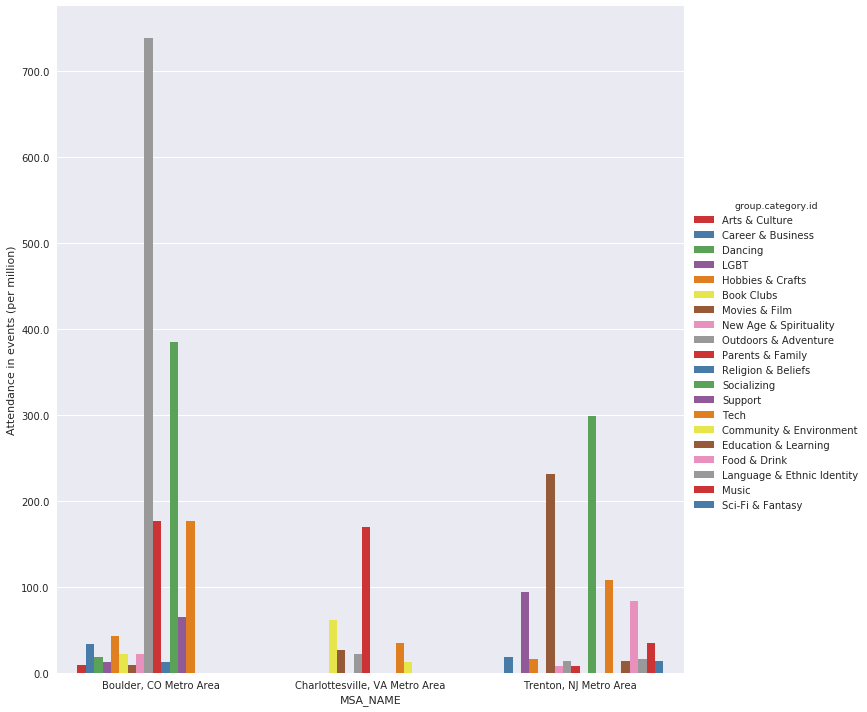

In [17]:
g = sns.factorplot(x='MSA_NAME', y='attendance_norm', hue='group.category.id', palette=sns.color_palette('Set1', 100), 
                   size=10, kind='bar', data=events_attendance)
g.set_ylabels('Attendance in events (per million)')
ax = g.axes.flatten()[0]
ax.set_yticklabels([ tick * 1000000 for tick in ax.get_yticks()])
print() 

In [18]:
trenton_top5 = events_attendance[ events_attendance['MSA_CODE'] == 45940].sort_values('attendance_norm', ascending=False).head()
cville_top5 = events_attendance[ events_attendance['MSA_CODE'] == 16820].sort_values('attendance_norm', ascending=False).head()
boulder_top5 = events_attendance[ events_attendance['MSA_CODE'] == 14500].sort_values('attendance_norm', ascending=False).head()

print('\nTrenton Top 5:\n', trenton_top5[ ['group.category.id', 'yes_rsvp_count'] ]) 
print('\nCville Top 5:\n', cville_top5[ ['group.category.id', 'yes_rsvp_count'] ])
print('\nBoulder Top 5:\n', boulder_top5[ ['group.category.id', 'yes_rsvp_count'] ])


Trenton Top 5:
    group.category.id  yes_rsvp_count
32       Socializing             111
26     Movies & Film              86
33              Tech              40
23              LGBT              35
22      Food & Drink              31

Cville Top 5:
        group.category.id  yes_rsvp_count
18      Parents & Family              39
15            Book Clubs              14
19                  Tech               8
16         Movies & Film               6
17  Outdoors & Adventure               5

Boulder Top 5:
        group.category.id  yes_rsvp_count
8   Outdoors & Adventure             238
11           Socializing             124
13                  Tech              57
9       Parents & Family              57
12               Support              21


### By attendance per million people and per event in each MSA 

In [19]:
# redo the events count due to some invalid rows being dropped (some MSAs did not have a pop. count)
events_count = augmented_df.groupby( ['MSA_CODE', 'MSA_NAME', 'group.category.id'] ).count().reset_index()

# normalize the attendance further by the number of events in each city and each category
events_attendance['attendance_norm'] = events_attendance['attendance_norm'] / events_count['id']

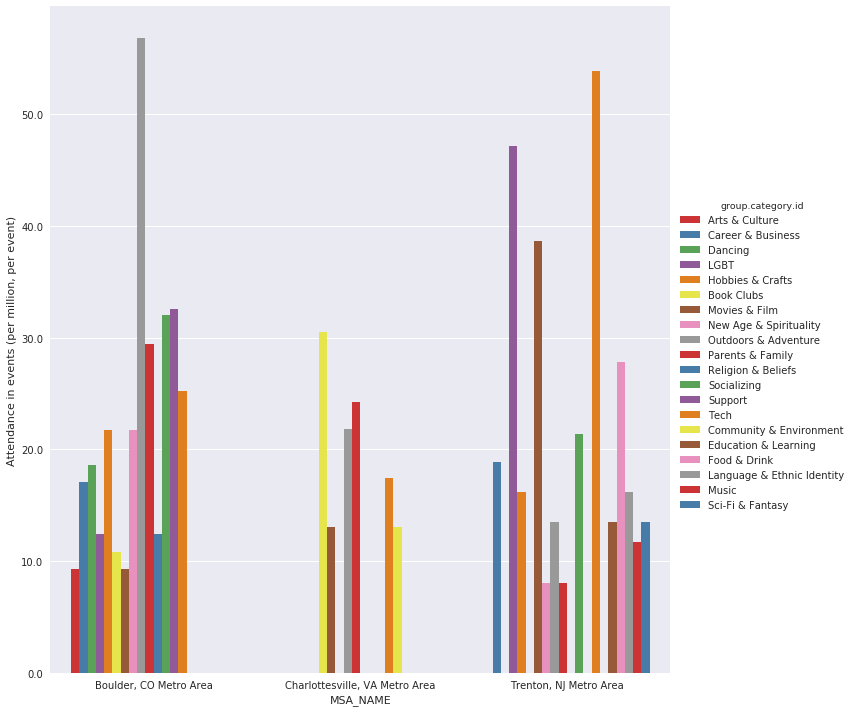

In [20]:
g = sns.factorplot(x='MSA_NAME', y='attendance_norm', hue='group.category.id', palette=sns.color_palette('Set1', 100), 
                   size=10, kind='bar', data=events_attendance)
g.set_ylabels('Attendance in events (per million, per event)')
ax = g.axes.flatten()[0]
ax.set_yticklabels( [ tick * 1000000 for tick in ax.get_yticks()] )
print()

In [21]:
trenton_top5 = events_attendance[ events_attendance['MSA_CODE'] == 45940].sort_values('attendance_norm', ascending=False).head()
cville_top5 = events_attendance[ events_attendance['MSA_CODE'] == 16820].sort_values('attendance_norm', ascending=False).head()
boulder_top5 = events_attendance[ events_attendance['MSA_CODE'] == 14500].sort_values('attendance_norm', ascending=False).head()

print('\nTrenton Top 5:\n', trenton_top5[ ['group.category.id', 'yes_rsvp_count'] ]) 
print('\nCville Top 5:\n', cville_top5[ ['group.category.id', 'yes_rsvp_count'] ])
print('\nBoulder Top 5:\n', boulder_top5[ ['group.category.id', 'yes_rsvp_count'] ])


Trenton Top 5:
    group.category.id  yes_rsvp_count
33              Tech              40
23              LGBT              35
26     Movies & Film              86
22      Food & Drink              31
32       Socializing             111

Cville Top 5:
        group.category.id  yes_rsvp_count
15            Book Clubs              14
18      Parents & Family              39
17  Outdoors & Adventure               5
19                  Tech               8
16         Movies & Film               6

Boulder Top 5:
        group.category.id  yes_rsvp_count
8   Outdoors & Adventure             238
12               Support              21
11           Socializing             124
9       Parents & Family              57
13                  Tech              57
